In [2]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [3]:
%load_ext blackcellmagic

In [4]:
from scr.analysis.perlayer import LayerLoss

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

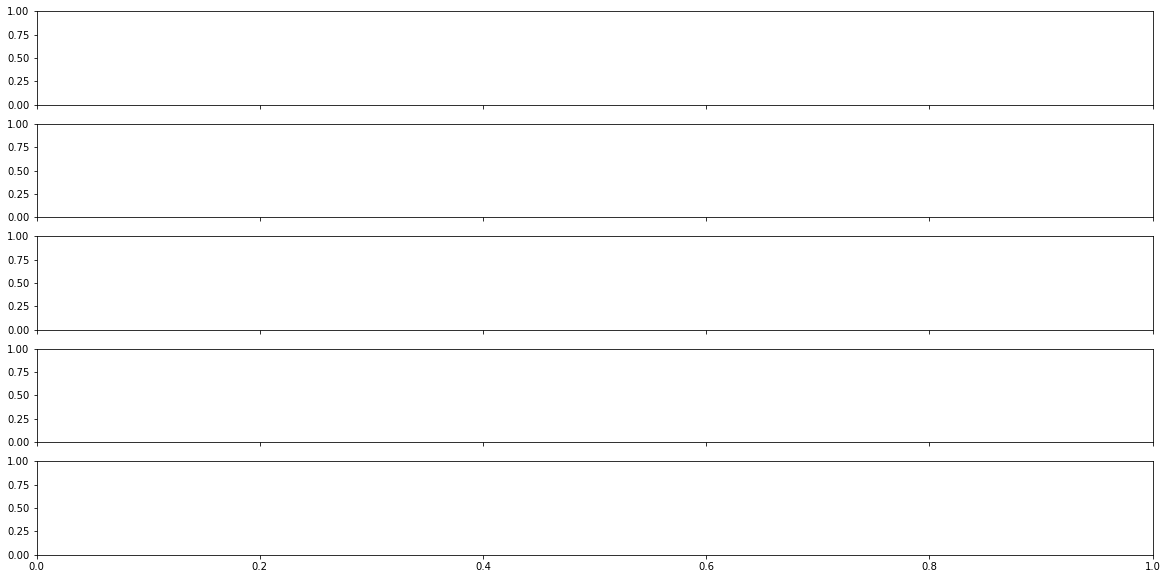

In [7]:
LayerLoss(
    input_path="test/pytorch_fixembpool",
    output_path="test/pytorch_fixembpool_layer"
)

In [6]:
LayerLoss(
    input_path="test/sklearn-scalex-scaley-noloader-fixembpool",
    output_path="test/sklearn-scalex-scaley-noloader-fixembpool_layer")

In [5]:
LayerLoss(
    input_path="test/sklearn-scaley-noloader-fixembpool",
    output_path="test/sklearn-scaley-noloader-fixembpool_layer")

Making test/sklearn-scaley-noloader-fixembpool_layer-onehot ...
Making test/sklearn-scaley-noloader-fixembpool_layer-onehot/proeng ...
Making test/sklearn-scaley-noloader-fixembpool_layer-onehot/proeng/thermo ...
Making test/sklearn-scaley-noloader-fixembpool_layer-onehot/proeng/thermo/mixed_split ...
Making test/sklearn-scaley-noloader-fixembpool_layer-onehot/proeng/thermo/mixed_split/onehot ...
Making test/sklearn-scaley-noloader-fixembpool_layer-onehot/proeng/thermo/mixed_split/onehot/flatten ...


In [8]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scalex-scaley-noloader-fixembpool",
    output_path="results/sklearn-scalex-scaley-noloader-fixembpool_layer",
).layer_analysis_dict

Making results/sklearn-scalex-scaley-noloader-fixembpool_layer/proeng/thermo ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer/proeng/thermo/mixed_split ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer/proeng/thermo/mixed_split/esm1_t34_670M_UR50S ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer/proeng/thermo/mixed_split/esm1_t34_670M_UR50S/mean ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer-rand/proeng/thermo ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer-rand/proeng/thermo/mixed_split ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer-rand/proeng/thermo/mixed_split/esm1_t34_670M_UR50S ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer-rand/proeng/thermo/mixed_split/esm1_t34_670M_UR50S/mean ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer-onehot/proeng/thermo ...
Making results/sklearn-scalex-scaley-noloader-fixembpool_layer-onehot/proeng/therm

In [21]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scaley-noloader-fixembpool",
    output_path="results/sklearn-scaley-noloader-fixembpool_layer",
).layer_analysis_dict

In [7]:
layer_analysis_dict.keys()

dict_keys(['proeng_gb1_two_vs_rest_mean', 'proeng_gb1_low_vs_high_mean', 'proeng_gb1_sampled_mean', 'proeng_aav_one_vs_many_mean', 'proeng_aav_two_vs_many_mean'])

In [8]:
layer_analysis_dict["proeng_gb1_sampled_mean"].keys()

dict_keys(['esm1_t34_670M_UR50S', 'esm1_t12_85M_UR50S', 'esm1b_t33_650M_UR50S', 'esm1_t6_43M_UR50S'])

In [9]:
layer_analysis_dict["proeng_gb1_sampled_mean"]["esm1_t6_43M_UR50S"].keys()

dict_keys(['train_mse', 'val_mse', 'test_mse', 'test_ndcg', 'test_rho'])

In [10]:
layer_analysis_dict["proeng_gb1_sampled_mean"]["esm1_t6_43M_UR50S"]["test_rho"]

array([       nan, 0.78954326, 0.82729954, 0.84882642, 0.85467853,
       0.84874573, 0.84821129])

In [11]:
from scr.utils import pickle_load

In [15]:
gb1_sample_output_dict = pickle_load("results/sklearn-scaley-noloader-fixembpool/proeng/gb1/sampled/esm1_t6_43M_UR50S/mean/esm1_t6_43M_UR50S-mean-layer_0.pkl")
gb1_sample_output_dict.keys(), gb1_sample_output_dict["test"].keys()

(dict_keys(['train', 'val', 'test']),
 dict_keys(['mse', 'pred', 'true', 'ndcg', 'rho']))

In [16]:
from scipy.stats import spearmanr

In [18]:
gb1_sample_output_dict["test"]["true"]

array([1.69016355e+00, 5.85648854e-01, 3.05454865e+00, ...,
       2.25273974e-03, 2.62819636e-02, 4.49316942e-03])

In [19]:
gb1_sample_output_dict["test"]["pred"]

array([4.51927324e-17, 4.51927324e-17, 4.51927324e-17, ...,
       4.51927324e-17, 4.51927324e-17, 4.51927324e-17])

In [17]:
spearmanr(gb1_sample_output_dict["test"]["true"], gb1_sample_output_dict["test"]["pred"])

/anaconda/envs/protran/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


SpearmanrResult(correlation=nan, pvalue=nan)

In [6]:
layer_analysis_dict = LayerLoss(
    input_path="results/train_val_test",
    output_path="results/analysis_layer",
).layer_analysis_dict

In [5]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scalex-scaley-noloader",
    output_path="results/sklearn-scalex-scaley-noloader_layer",
).layer_analysis_dict

In [4]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scaley-noloader",
    output_path="results/sklearn-scaley-noloader_layer",
).layer_analysis_dict

In [10]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scaley-noloader-rand",
    output_path="results/sklearn-scaley-noloader-rand_layer",
).layer_analysis_dict

Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1b_t33_650M_UR50S ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1b_t33_650M_UR50S/mean ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1_t6_43M_UR50S ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1_t6_43M_UR50S/mean ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1_t12_85M_UR50S ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1_t12_85M_UR50S/mean ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1_t34_670M_UR50S ...
Making results/sklearn-scaley-noloader-rand_layer/proeng/gb1/sampled/esm1_t34_670M_UR50S/mean ...


In [6]:
from scr.params.emb import TRANSFORMER_INFO

In [9]:
[""] + list(TRANSFORMER_INFO.keys())

['',
 'esm1_t6_43M_UR50S',
 'esm1_t12_85M_UR50S',
 'esm1_t34_670M_UR50S',
 'esm1b_t33_650M_UR50S']

In [8]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scaley-fixa-noloader",
    output_path="results/sklearn-scaley-fixa-noloader_layer",
).layer_analysis_dict

In [6]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scaley-fixa",
    output_path="results/sklearn-scaley-fixa_layer",
).layer_analysis_dict

In [32]:
layer_analysis_dict.keys(), layer_analysis_dict["proeng_gb1_low_vs_high_mean"].keys(), layer_analysis_dict["proeng_gb1_low_vs_high_mean"]["esm1b_t33_650M_UR50S"].keys()

(dict_keys(['proeng_gb1_two_vs_rest_mean', 'proeng_gb1_low_vs_high_mean', 'proeng_aav_one_vs_many_mean']),
 dict_keys(['esm1b_t33_650M_UR50S', 'esm1_t6_43M_UR50S', 'esm1_t12_85M_UR50S', 'esm1_t34_670M_UR50S']),
 dict_keys(['train_mse', 'test_ndcg', 'test_rho']))

In [26]:
layer_analysis_dict = LayerLoss(
    input_path="results/sklearn-scaley-noloader",
    output_path="results/sklearn-scaley-noloader_layer",
).layer_analysis_dict

Making results/sklearn-scaley-noloader_layer-onehot ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1 ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/sampled ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/sampled/onehot ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/sampled/onehot/flatten ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/two_vs_rest ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/two_vs_rest/onehot ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/two_vs_rest/onehot/flatten ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/low_vs_high ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/low_vs_high/onehot ...
Making results/sklearn-scaley-noloader_layer-onehot/proeng/gb1/low_vs_high/onehot/flatten ...
Making results/sklearn-scaley-noloader_layer-oneh